In [2]:
import rasterio
import keras
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape, Bidirectional
from keras.layers import Conv2D, MaxPooling2D, ConvLSTM2D, TimeDistributed, UpSampling2D, Concatenate
from keras.layers import Activation, BatchNormalization
from keras.optimizers import SGD, Adadelta, Adam
from keras import Input
from keras import Model
import os
import sys
from sklearn.utils import class_weight
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import utilities as util
import importlib
import rnn_tiles
import rnn_pixels
import numpy as np
importlib.reload(rnn_pixels)
importlib.reload(rnn_tiles)

<module 'rnn_tiles' from '/host/Desktop/cnn_dev/florence_mapping/rcnn/rnn_tiles.py'>

In [30]:
util.class_to_index

{11: 0,
 21: 3,
 22: 1,
 23: 1,
 24: 1,
 31: 4,
 41: 2,
 42: 2,
 43: 2,
 52: 2,
 71: 3,
 81: 3,
 82: 3,
 90: 2,
 95: 5}

In [4]:
def strangeBlock(input_block, nb_layers, filters):
    x_list = [input_block]
    c_temp = input_block
    for i in range(nb_layers):
        c_l = ConvLSTM2D(filters=filters,kernel_size=(3,3), activation='elu', padding = 'same', return_sequences=True) (c_temp)
        x_list.append(c_l)
        merge = Concatenate()(x_list)
        c_temp = merge
    return c_temp
    

In [5]:
def strangeBlock_v2(input_block, nb_layers, filters):
    x_list = [input_block]
    c_temp = input_block
    for i in range(nb_layers):
        c_l = Bidirectional(ConvLSTM2D(filters=filters,kernel_size=(3,3), activation='elu', padding = 'same', return_sequences=True)) (c_temp)
        x_list.append(c_l)
        merge = Concatenate()(x_list)
        c_temp = merge
    return c_temp
    

In [6]:
def strange_network_v3(input_shape, class_count):
    input_img = Input(input_shape)
    strange_block_1 = strangeBlock(input_img, 4, 20)
    #pool_1 = TimeDistributed(MaxPooling2D((3,3), padding='same')) (strange_block_1)
    strange_block_2 = strangeBlock(strange_block_1, 4, 20)
    conv_lc = ConvLSTM2D(filters=class_count,kernel_size=(1,1), activation='softmax', padding = 'same', return_sequences=False, name='landcover') (strange_block_2)
    reshaping = Reshape((64*64,class_count)) (conv_lc)
    #conv_out_cc = ConvLSTM2D(filters=1,kernel_size=(1,1), padding = 'same', return_sequences=False, name='canopy')(conv_1)
    model = Model(inputs=input_img, outputs=reshaping)  # conv_out_cc])
    return model
    

In [7]:
def strange_network_v4(input_shape, class_count):
    input_img = Input(input_shape)
    strange_block_1 = strangeBlock_v2(input_img, 4, 20)
    #pool_1 = TimeDistributed(MaxPooling2D((3,3), padding='same')) (strange_block_1)
    strange_block_2 = strangeBlock_v2(strange_block_1, 4, 20)
    conv_lc = ConvLSTM2D(filters=class_count,kernel_size=(1,1), activation='softmax', padding = 'same', return_sequences=False, name='landcover') (strange_block_2)
    reshaping = Reshape((64*64,class_count)) (conv_lc)
    #conv_out_cc = ConvLSTM2D(filters=1,kernel_size=(1,1), padding = 'same', return_sequences=False, name='canopy')(conv_1)
    model = Model(inputs=input_img, outputs=reshaping)  # conv_out_cc])
    return model
    

In [8]:
def strange_network_v2(input_shape, class_count):
    input_img = Input(input_shape)
    strange_block_1 = strangeBlock(input_img, 4, 20)
    pool_1 = TimeDistributed(MaxPooling2D((3,3), padding='same')) (strange_block_1)
    strange_block_2 = strangeBlock(pool_1, 4, 20)
    upsample_1 = TimeDistributed(UpSampling2D((3,3))) (strange_block_2)
    conv_1 = TimeDistributed(Conv2D(32, (3,3)))(upsample_1)
    conv_lc = ConvLSTM2D(filters=class_count,kernel_size=(1,1), activation='softmax', padding = 'same', return_sequences=False, name='landcover') (conv_1)
    reshaping = Reshape((64*64,class_count)) (conv_lc)
    #conv_out_cc = ConvLSTM2D(filters=1,kernel_size=(1,1), padding = 'same', return_sequences=False, name='canopy')(conv_1)
    model = Model(inputs=input_img, outputs=reshaping)  # conv_out_cc])
    return model

In [9]:
lc_labels = rasterio.open('/deep_data/recurrent_data/NLCD_DATA/landcover/NLCD_2011_Land_Cover_L48_20190424.img')
canopy_labels = rasterio.open('/deep_data/recurrent_data/NLCD_DATA/canopy/CONUSCartographic_2_8_16/Cartographic/nlcd2011_usfs_conus_canopy_cartographic.img')

In [10]:
tiles = {}
landsat_datasets = {}
tiles['028012'] = ['20110324', '20110612', '20110831', '20111103']
tiles['029011'] = ['20110308', '20110425', '20110831', '20111103']
tiles['028011'] = ['20110308', '20110628', '20110831', '20111103']
for tile_number, dates in tiles.items():
    tile_datasets = []
    l8_image_paths = []
    for date in dates:
        l8_image_paths.append('/deep_data/recurrent_data/tile{}/combined/combined{}.tif'.format(tile_number, date))
    for fp in l8_image_paths:
        tile_datasets.append(rasterio.open(fp))
    landsat_datasets[tile_number] = tile_datasets

In [11]:
tile_size = 64
tile_list = ['028012', '029011', '028011']
class_count = 6
epochs = 200
batch_size = 25

In [12]:
px = rnn_pixels.make_pixels(tile_size, tile_list)

In [ ]:
pixels = rnn_pixels.delete_bad_tiles(landsat_datasets,lc_labels, canopy_labels, px, tile_size)

In [ ]:
len(pixels)

In [ ]:
train_px, val_px, test_px = rnn_pixels.train_val_test_split(pixels, 0.7, 0.7)

In [ ]:
model = strange_network_v4((4, 64, 64, 7), class_count)
model = keras.utils.multi_gpu_model(model, 4)

In [48]:
tile_gen = rnn_tiles.rnn_tile_gen(landsat_datasets, lc_labels, canopy_labels, tile_size, class_count)

In [50]:
filepath ='strange_v3_merged.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [51]:
callbacks_list = [checkpoint]

In [52]:
def jaccard_distance(y_true, y_pred, smooth=100):
    """Jaccard distance for semantic segmentation.
    Also known as the intersection-over-union loss.
    This loss is useful when you have unbalanced numbers of pixels within an image
    because it gives all classes equal weight. However, it is not the defacto
    standard for image segmentation.
    For example, assume you are trying to predict if
    each pixel is cat, dog, or background.
    You have 80% background pixels, 10% dog, and 10% cat.
    If the model predicts 100% background
    should it be be 80% right (as with categorical cross entropy)
    or 30% (with this loss)?
    The loss has been modified to have a smooth gradient as it converges on zero.
    This has been shifted so it converges on 0 and is smoothed to avoid exploding
    or disappearing gradient.
    Jaccard = (|X & Y|)/ (|X|+ |Y| - |X & Y|)
            = sum(|A*B|)/(sum(|A|)+sum(|B|)-sum(|A*B|))
    # Arguments
        y_true: The ground truth tensor.
        y_pred: The predicted tensor
        smooth: Smoothing factor. Default is 100.
    # Returns
        The Jaccard distance between the two tensors.
    # References
        - [What is a good evaluation measure for semantic segmentation?](
           http://www.bmva.org/bmvc/2013/Papers/paper0032/paper0032.pdf)
    """
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac) * smooth

In [53]:
model.compile(optimizer=Adam(), loss=jaccard_distance, metrics=['accuracy'])

In [64]:
model.fit_generator(generator=tile_gen.tile_generator(train_px, batch_size), 
                    steps_per_epoch=len(train_px) // batch_size, epochs=epochs, verbose=1,
                    validation_data=tile_gen.tile_generator(val_px, batch_size),
                    validation_steps=len(val_px) // batch_size, callbacks=callbacks_list) #class_weight=weights, callbacks=callbacks_list) 

Epoch 1/200
69/69 [==============================] - 57s 819ms/step - loss: 0.2662 - acc: 0.8856 - val_loss: 0.2618 - val_acc: 0.8849

Epoch 00001: val_acc did not improve from 0.89481
Epoch 2/200
69/69 [==============================] - 56s 808ms/step - loss: 0.2638 - acc: 0.8848 - val_loss: 0.2575 - val_acc: 0.8931

Epoch 00002: val_acc did not improve from 0.89481
Epoch 3/200
69/69 [==============================] - 56s 809ms/step - loss: 0.2636 - acc: 0.8865 - val_loss: 0.2577 - val_acc: 0.8910

Epoch 00003: val_acc did not improve from 0.89481
Epoch 4/200
69/69 [==============================] - 56s 809ms/step - loss: 0.2644 - acc: 0.8867 - val_loss: 0.2564 - val_acc: 0.8949

Epoch 00004: val_acc improved from 0.89481 to 0.89486, saving model to strange_v3_merged.hdf5
Epoch 5/200
69/69 [==============================] - 56s 811ms/step - loss: 0.2655 - acc: 0.8855 - val_loss: 0.2575 - val_acc: 0.8892

Epoch 00005: val_acc did not improve from 0.89486
Epoch 6/200
69/69 [============

69/69 [==============================] - 56s 809ms/step - loss: 0.2637 - acc: 0.8871 - val_loss: 0.2560 - val_acc: 0.8904

Epoch 00044: val_acc did not improve from 0.90012
Epoch 45/200
69/69 [==============================] - 56s 810ms/step - loss: 0.2638 - acc: 0.8879 - val_loss: 0.2509 - val_acc: 0.8994

Epoch 00045: val_acc did not improve from 0.90012
Epoch 46/200
69/69 [==============================] - 56s 809ms/step - loss: 0.2616 - acc: 0.8883 - val_loss: 0.2530 - val_acc: 0.8972

Epoch 00046: val_acc did not improve from 0.90012
Epoch 47/200
69/69 [==============================] - 56s 810ms/step - loss: 0.2617 - acc: 0.8880 - val_loss: 0.2526 - val_acc: 0.8930

Epoch 00047: val_acc did not improve from 0.90012
Epoch 48/200
69/69 [==============================] - 56s 809ms/step - loss: 0.2604 - acc: 0.8890 - val_loss: 0.2518 - val_acc: 0.8979

Epoch 00048: val_acc did not improve from 0.90012
Epoch 49/200
69/69 [==============================] - 56s 811ms/step - loss: 0.2602

69/69 [==============================] - 56s 807ms/step - loss: 0.2626 - acc: 0.8897 - val_loss: 0.2565 - val_acc: 0.8952

Epoch 00132: val_acc did not improve from 0.90012
Epoch 133/200
69/69 [==============================] - 56s 807ms/step - loss: 0.2778 - acc: 0.8793 - val_loss: 0.2758 - val_acc: 0.8817

Epoch 00133: val_acc did not improve from 0.90012
Epoch 134/200
69/69 [==============================] - 56s 807ms/step - loss: 0.2742 - acc: 0.8765 - val_loss: 0.2632 - val_acc: 0.8804

Epoch 00134: val_acc did not improve from 0.90012
Epoch 135/200
69/69 [==============================] - 56s 807ms/step - loss: 0.2685 - acc: 0.8797 - val_loss: 0.2566 - val_acc: 0.8841

Epoch 00135: val_acc did not improve from 0.90012
Epoch 136/200
69/69 [==============================] - 56s 807ms/step - loss: 0.2642 - acc: 0.8819 - val_loss: 0.2545 - val_acc: 0.8919

Epoch 00136: val_acc did not improve from 0.90012
Epoch 137/200
69/69 [==============================] - 56s 807ms/step - loss: 0

69/69 [==============================] - 56s 805ms/step - loss: 0.2617 - acc: 0.8869 - val_loss: 0.2581 - val_acc: 0.8864

Epoch 00176: val_acc did not improve from 0.90012
Epoch 177/200
69/69 [==============================] - 56s 805ms/step - loss: 0.2623 - acc: 0.8860 - val_loss: 0.2547 - val_acc: 0.8947

Epoch 00177: val_acc did not improve from 0.90012
Epoch 178/200
69/69 [==============================] - 56s 806ms/step - loss: 0.2680 - acc: 0.8858 - val_loss: 0.2637 - val_acc: 0.8895

Epoch 00178: val_acc did not improve from 0.90012
Epoch 179/200
69/69 [==============================] - 56s 806ms/step - loss: 0.2685 - acc: 0.8855 - val_loss: 0.2607 - val_acc: 0.8897

Epoch 00179: val_acc did not improve from 0.90012
Epoch 180/200
69/69 [==============================] - 56s 806ms/step - loss: 0.2681 - acc: 0.8820 - val_loss: 0.2781 - val_acc: 0.8723

Epoch 00180: val_acc did not improve from 0.90012
Epoch 181/200
69/69 [==============================] - 56s 806ms/step - loss: 0

In [65]:
model.load_weights('strange_v3_merged.hdf5')

In [66]:
predictions = model.predict_generator(generator = tile_gen.tile_generator(test_px, batch_size=1), steps=len(test_px) // 1, verbose=1)
eval_generator = tile_gen.tile_generator(test_px, batch_size=1)


381/381 [==============================] - 25s 66ms/step


In [67]:
print(predictions.shape)

(381, 4096, 6)


In [68]:
pred = np.argmax(predictions,axis=-1)

In [69]:
labels = np.empty(pred.shape)
count = 0
while count < len(labels):
        image_b, label_b = next(eval_generator)
        label_b = np.argmax(label_b, axis=-1)
        labels[count] = label_b
        count += 1


In [70]:
label_index = labels.reshape(len(test_px)*4096)
pred_index = pred.reshape(len(test_px)*4096)

In [71]:
pred_index.shape

(1560576,)

In [72]:
importlib.reload(util)

<module 'utilities' from '/host/Desktop/cnn_dev/florence_mapping/utilities.py'>

Accuracy is 0.8965990762385171


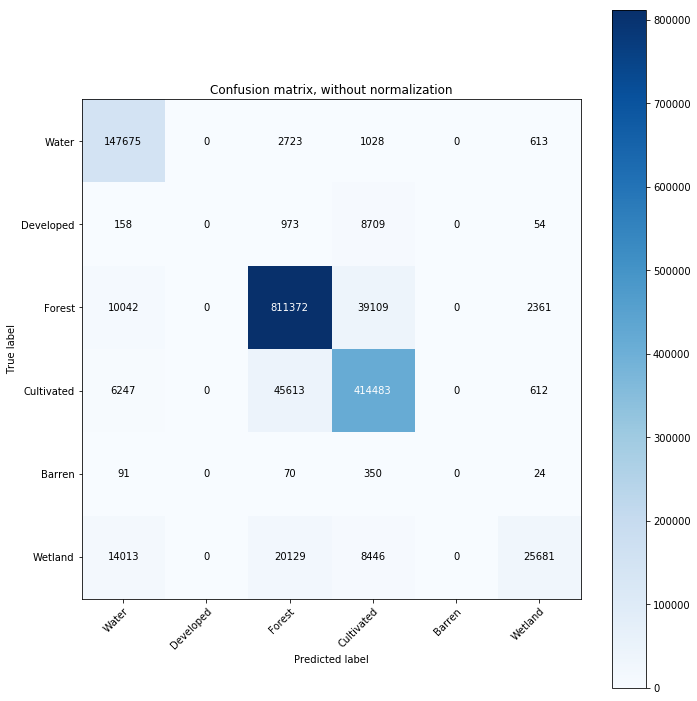

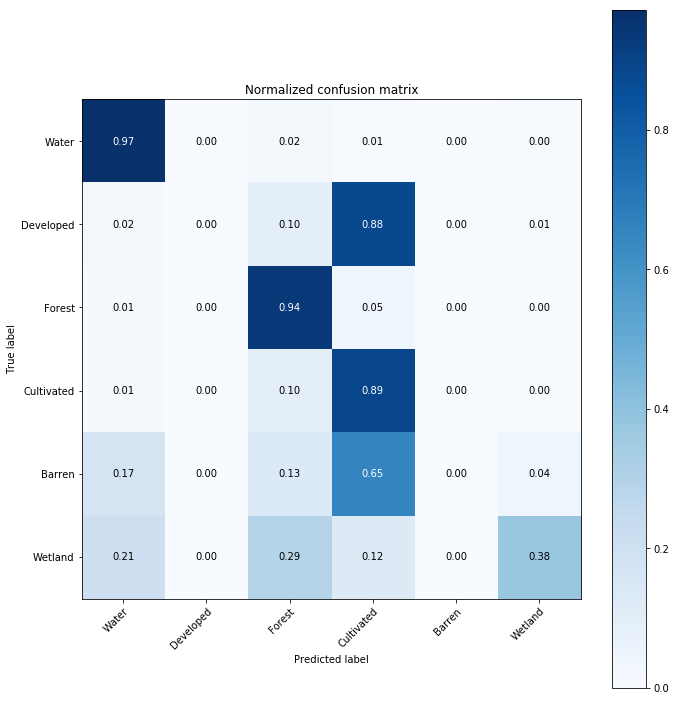

In [73]:
np.set_printoptions(precision=2)
# Plot non-normalized confusion matrix
util.plot_confusion_matrix(label_index.astype(np.int), pred_index.astype(np.int), classes=np.array(list(util.indexed_dictionary)),
                      class_dict=util.indexed_dictionary)
# Plot normalized confusion matrix
util.plot_confusion_matrix(label_index.astype(np.int), pred_index.astype(np.int), classes=np.array(list(util.indexed_dictionary)),
                      class_dict=util.indexed_dictionary,
                      normalize=True)
count = 0
for i in range(len(label_index)):
    if(label_index[i] == pred_index[i]):
        count+=1
print("Accuracy is {}".format(count/len(label_index)))

In [ ]:
from sklearn.utils.multiclass import unique_labels


In [ ]:
unique_labels(label_index, pred_index)

In [ ]:
def strange_network(input_shape):
    input_img = Input(input_shape)
    #c_l1 = ConvLSTM2D(filters=32,kernel_size=(2,2), activation='elu', padding = 'same', return_sequences=True) (input_img)
    #c_l2 = ConvLSTM2D(filters=32,kernel_size=(2,2), activation='elu', padding = 'same', return_sequences=True) (c_l1)
    c_l3 = ConvLSTM2D(filters=32,kernel_size=(2,2), activation='elu', padding = 'same', return_sequences=True) (input_img)
    #pool_1 = TimeDistributed(MaxPooling2D((3,3), padding='same')) (c_l3)
    #c_l4 = ConvLSTM2D(filters=32,kernel_size=(2,2), activation='elu', padding = 'same', return_sequences=True) (pool_1)
    #c_l5 = ConvLSTM2D(filters=32,kernel_size=(2,2), activation='elu', padding = 'same', return_sequences=True) (c_l4)
    #c_l6 = ConvLSTM2D(filters=32,kernel_size=(2,2), activation='elu', padding = 'same', return_sequences=True) (pool_1)
    #upsample_1 = TimeDistributed(UpSampling2D((3,3))) (c_l6)
    conv_1 = TimeDistributed(Conv2D(32, (3,3), padding='same'))(c_l3)
    #merge = Concatenate()([c_l3, conv_1])
    conv_lc = ConvLSTM2D(filters=16,kernel_size=(1,1), activation='softmax', padding = 'same', return_sequences=False) (conv_1)
    #conv_out_cc = ConvLSTM2D(filters=1,kernel_size=(1,1), activation='sigmoid', padding = 'same', return_sequences=False)(merge)
    #model = Model(inputs=input_img, outputs=[conv_lc, conv_out_cc])
    model = Model(inputs=input_img, outputs=conv_lc)
    return model

    


In [ ]:
w_tile_gen = rnn_tiles.rnn_tile_gen(landsat_datasets, lc_labels, canopy_labels, tile_size, class_count)
w_generator = w_tile_gen.tile_generator(pixels, batch_size=1)
total_labels = list()
count = 0
while count < len(pixels):
        image_b, label_b = next(w_generator)
        label_b = np.argmax(label_b, axis=-1)
        total_labels.append(label_b)
        count+=1
total_labels = np.asarray(total_labels)
total_labels = total_labels.reshape(len(total_labels)*64*64)
buckets = {0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0, 10:0, 11:0}
for label in total_labels:
    buckets[label] +=1
print(buckets)
weights_list = class_weight.compute_class_weight('balanced', np.unique(total_labels), total_labels)